## Run the set up

In [ ]:
import os
import cv2
import random
import torch
import warnings
import pandas as pd
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.optim.lr_scheduler as scheduler

from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

In [ ]:
from torchvision import datasets, transforms

In [ ]:
from tqdm import trange

In [ ]:
def generate_df(directory: str, categories: dict) -> pd.DataFrame:
    data = []

    for category, label in categories.items():
        category_path = os.path.join(directory, category)
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            data.append([file_path, label])

    return pd.DataFrame(data, columns=['path', 'label'])

In [ ]:
def read_img(path: str, size: tuple[int, int]):
    img = cv2.imread(img_path)

    return cv2.resize(img, size)

## Change the path_to_file accordingly
### The data is available at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_to_file = '/content/drive/My Drive/chest_xray'

Mounted at /content/drive


## Build the dataloader

In [ ]:
TRAIN_PATH = f'{path_to_file}/train'
TEST_PATH = f'{path_to_file}/test'
VALID_PATH = f'{path_to_file}/valid'

CATEGORIES = {
    'PNEUMONIA': 1,
    'NORMAL': 0
}

train_df = generate_df(TRAIN_PATH, CATEGORIES)
test_df = generate_df(TEST_PATH, CATEGORIES)

In [ ]:
train_df.head()

,path,label
0,person566_virus_1106.jpeg,PNEUMONIA
1,person537_bacteria_2265.jpeg,PNEUMONIA
2,person563_bacteria_2335.jpeg,PNEUMONIA
3,person543_bacteria_2279.jpeg,PNEUMONIA
4,person531_bacteria_2241.jpeg,PNEUMONIA


In [ ]:
class ChestXRay(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = ChestXRay(dataframe=train_df, transform=transform)

test_dataset = ChestXRay(dataframe=test_df, transform=transform)

In [ ]:
batch_size=32

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

Images shape:  torch.Size([32, 3, 224, 224])
Labels shape:  torch.Size([32])
Mean=0.46735844016075134, Std=0.23039603233337402


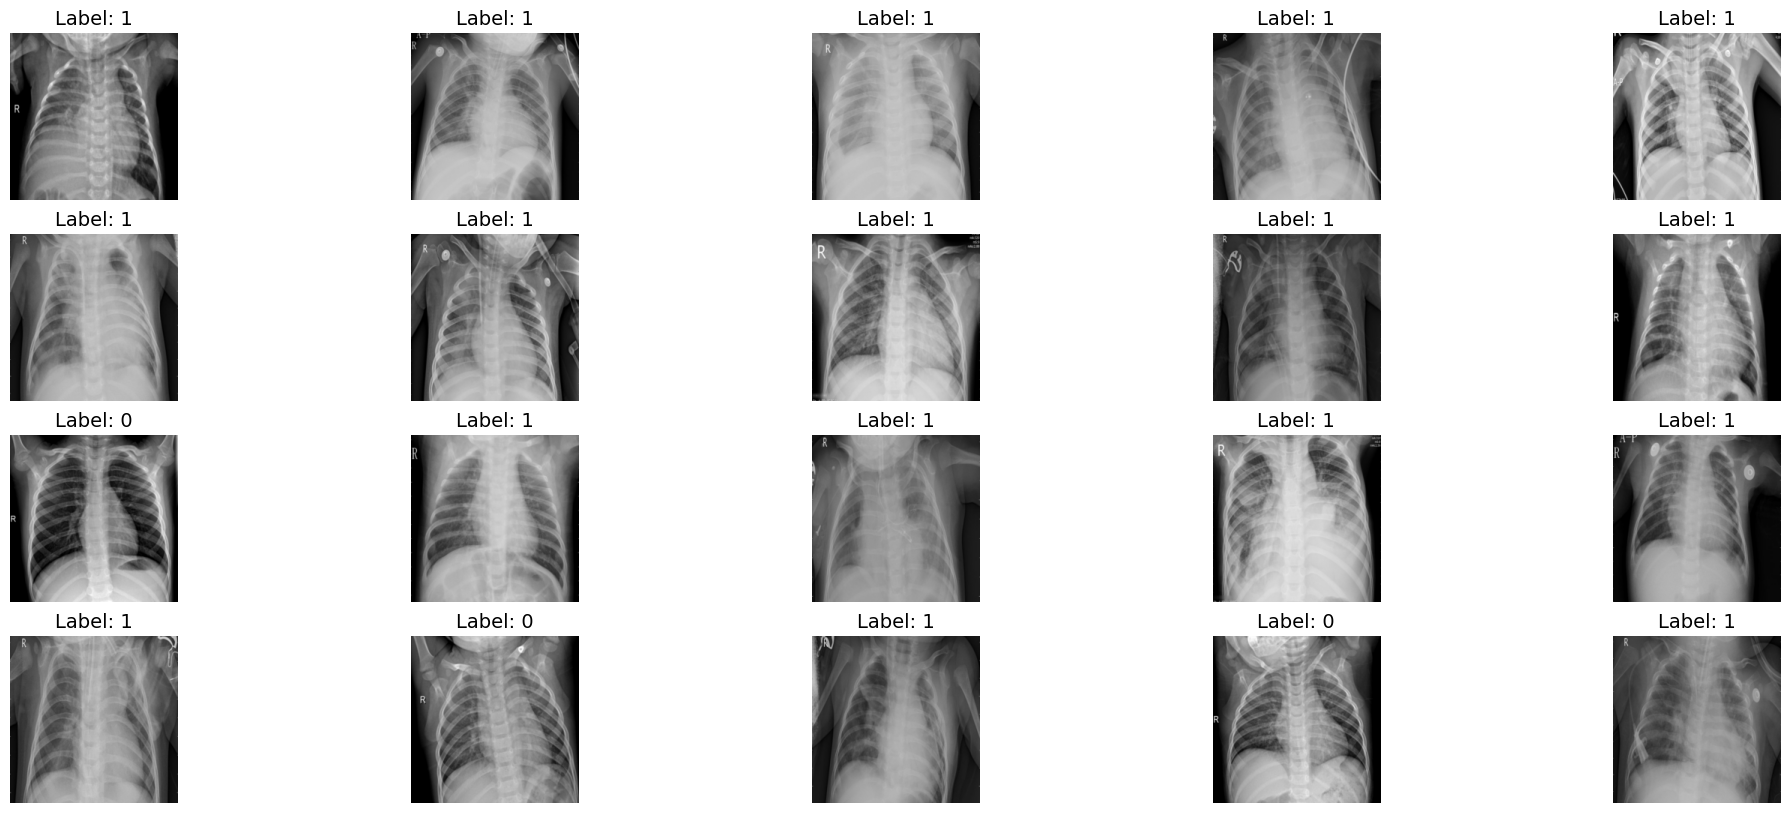

In [ ]:
images, labels = next(iter(train_loader))

print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(25, 10))

indices = np.random.choice(len(images), 20, replace=False)
selected_images = images[indices]
selected_labels = labels[indices]

for idx in range(20):
  plt.subplot(4, 5, idx+1)
  plt.imshow(np.transpose(selected_images[idx], (1, 2, 0)))
  plt.title(f'Label: {selected_labels[idx]}', fontsize=14)
  plt.axis('off')

plt.show()

## Build the model

In [77]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # The input size here depends on the output size of the last conv layer
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply conv followed by pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 256 * 14 * 14)  # Flatten the tensor

        # Apply fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(DEVICE)

## Train and save the model
don't need to run if you don't want to reproduce it

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

In [ ]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0

    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)
            pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
            num_correct += pred.eq(label.view_as(pred)).sum().item()
            test_loss += F.cross_entropy(output, label, reduction='sum').item()

    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [78]:
# Hyperparameters
lr = 0.01
max_epochs=100
# gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30], gamma=0.5)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

    scheduler.step()

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs: 100%|██████████| 100/100 [2:30:36<00:00, 90.37s/it]

Test accuracy: 0.7852564102564102


In [82]:
path_to_save_model = '/content/drive/My Drive/model.pth'
torch.save(model.state_dict(), path_to_save_model)

In [83]:
train_loss, num_correct = test_one_epoch(train_loader, model, DEVICE)
print(f"Train accuracy: {num_correct/len(train_loader.dataset)}")

Train accuracy: 0.9978911042944786


## Load the model

In [ ]:
model.load_state_dict(torch.load('model.pth', map_location=torch.device('mps')))

In [ ]:
## if you want to predict one img, use the following code but keep the same dataframe as above
output = model(img)
pred = output.argmax(dim=1, keepdim=True)

## Other tests

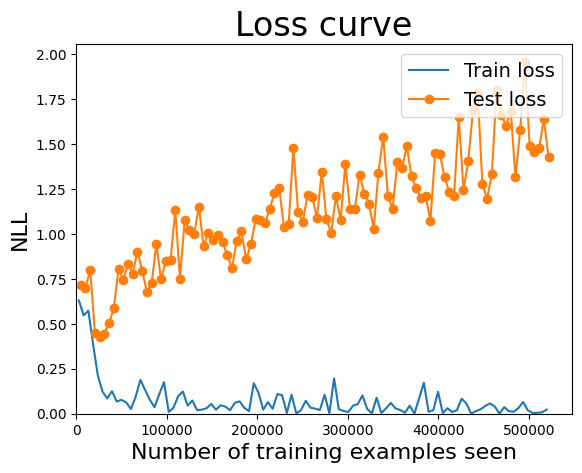

In [79]:
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)],
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

plt.show()

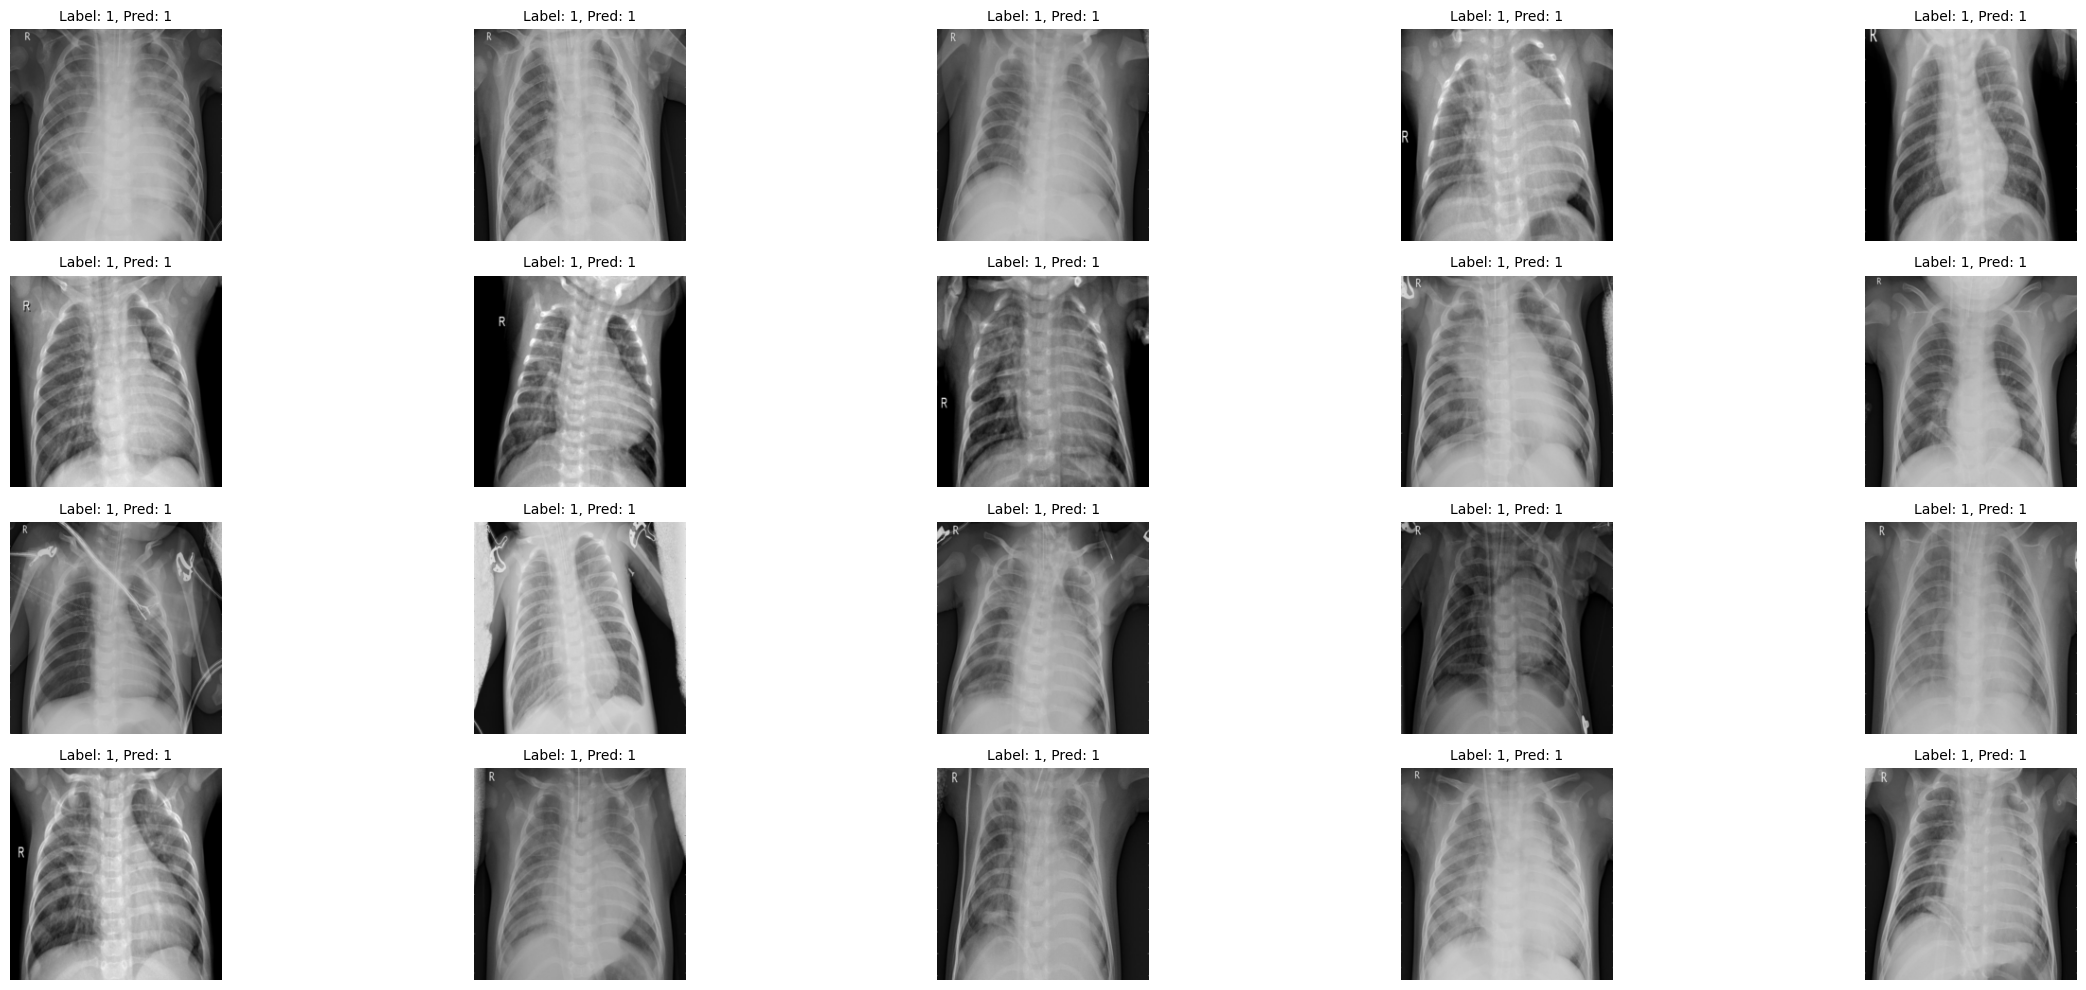

In [80]:
images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(25, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(np.transpose(images[i].cpu(), (1, 2, 0)))
    plt.title(f'Label: {labels[i]}, Pred: {pred[i]}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

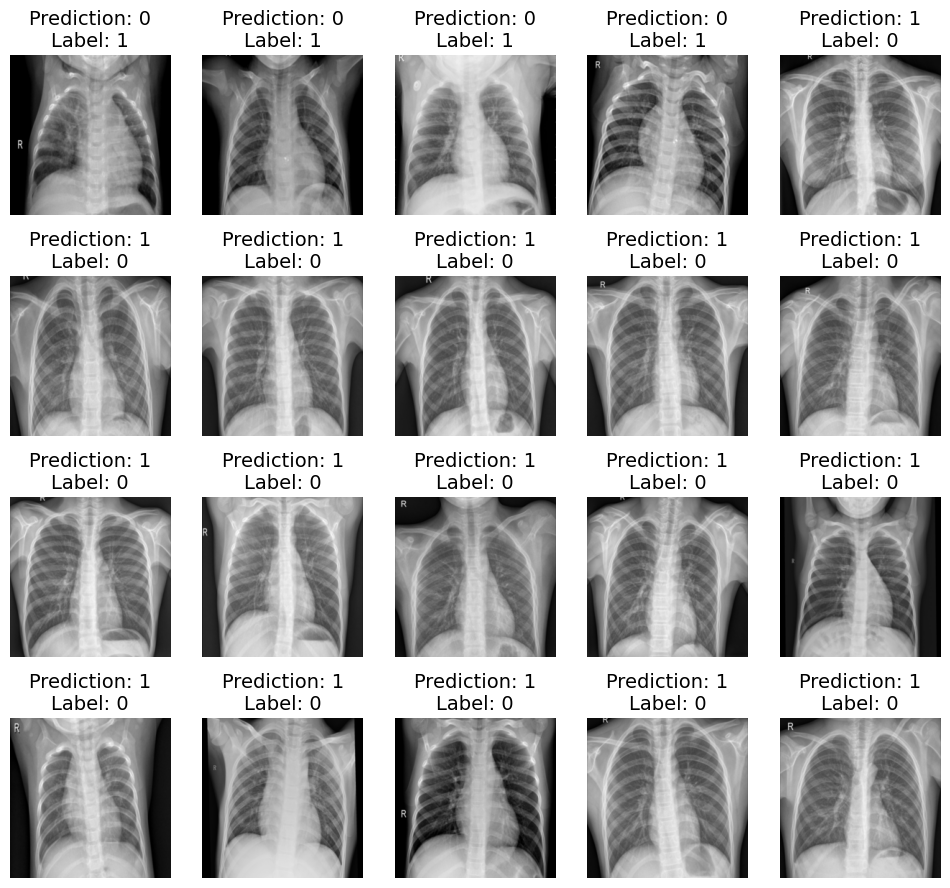

In [81]:
incorrect_imgs = torch.Tensor().to(DEVICE)
incorrect_preds = torch.IntTensor().to(DEVICE)
incorrect_labels = torch.IntTensor().to(DEVICE)

with torch.no_grad():
    # Test set iterator
    it = iter(test_loader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        images, labels = next(it)
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = model(images)
        pred = output.argmax(dim=1)

        incorrect_indices = ~pred.eq(labels.view_as(pred))

        if incorrect_indices.sum().item() > 0:
            incorrect_batch_imgs = images[incorrect_indices]
            incorrect_batch_preds = pred[incorrect_indices]
            incorrect_batch_labels = labels[incorrect_indices]

            incorrect_imgs = torch.cat((incorrect_imgs, incorrect_batch_imgs), dim=0)
            incorrect_preds = torch.cat((incorrect_preds, incorrect_batch_preds), dim=0)
            incorrect_labels = torch.cat((incorrect_labels, incorrect_batch_labels), dim=0)

        if incorrect_imgs.size(0) >= 20:
            break

# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(np.transpose(incorrect_imgs[i].cpu(), (1, 2, 0)))
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')